# Step 7: Threshold Tuning & Model Optimization

Default classification thresholds (0.5) are not optimal for imbalanced fraud detection problems.

This step optimizes the decision threshold to improve fraud recall while maintaining acceptable precision. The goal is to align model predictions with business risk priorities.


In [1]:
# load libraries
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt



In [4]:
# Reload feature-engineered dataset
df = pd.read_csv("../data/processed/feature_engineered_raw.csv")

X = df.drop('FraudFound_P', axis=1)
y = df['FraudFound_P']

# Encode again (same as Step 6)
X_encoded = pd.get_dummies(X, drop_first=True)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded,
    y,
    test_size=0.25,
    random_state=42,
    stratify=y
)


In [2]:
rf_model = joblib.load(
    "../models/random_forest_model.pkl"
)

print("Random Forest model loaded.")


Random Forest model loaded.


In [5]:
# Fraud possibilities

y_prob = rf_model.predict_proba(X_test)[:, 1]


### ROC Curve

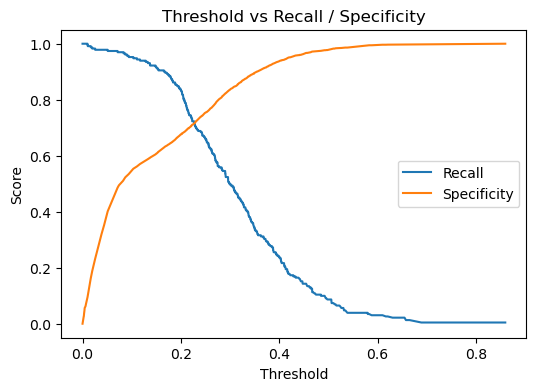

In [6]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_test, y_prob)

plt.figure(figsize=(6,4))
plt.plot(thresholds, tpr, label="Recall")
plt.plot(thresholds, 1 - fpr, label="Specificity")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Threshold vs Recall / Specificity")
plt.legend()
plt.show()


### Precision–Recall Curve

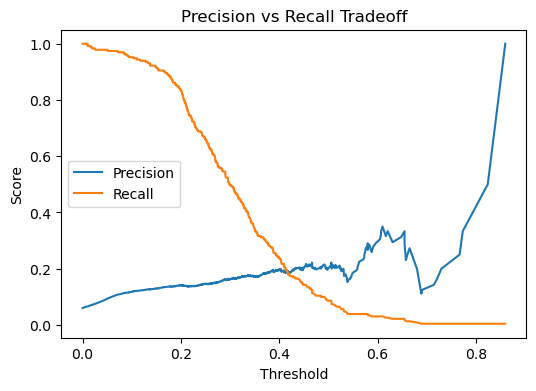

In [7]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds_pr = precision_recall_curve(
    y_test,
    y_prob
)

plt.figure(figsize=(6,4))
plt.plot(thresholds_pr, precision[:-1], label="Precision")
plt.plot(thresholds_pr, recall[:-1], label="Recall")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.title("Precision vs Recall Tradeoff")
plt.legend()
plt.show()


### Multi‑Threshold Evaluation

In [8]:
from sklearn.metrics import classification_report

threshold_list = [0.5, 0.4, 0.3, 0.25, 0.2, 0.15]

for t in threshold_list:
    y_pred_tuned = (y_prob >= t).astype(int)
    
    print(f"\nThreshold: {t}")
    print(classification_report(y_test, y_pred_tuned))



Threshold: 0.5
              precision    recall  f1-score   support

           0       0.94      0.98      0.96      3624
           1       0.20      0.09      0.12       231

    accuracy                           0.93      3855
   macro avg       0.57      0.53      0.54      3855
weighted avg       0.90      0.93      0.91      3855


Threshold: 0.4
              precision    recall  f1-score   support

           0       0.95      0.94      0.94      3624
           1       0.20      0.24      0.21       231

    accuracy                           0.90      3855
   macro avg       0.57      0.59      0.58      3855
weighted avg       0.91      0.90      0.90      3855


Threshold: 0.3
              precision    recall  f1-score   support

           0       0.96      0.84      0.90      3624
           1       0.16      0.50      0.25       231

    accuracy                           0.82      3855
   macro avg       0.56      0.67      0.57      3855
weighted avg       0.92   

### Final Threshold Selection

In [9]:
final_threshold = 0.25

y_pred_final = (y_prob >= final_threshold).astype(int)

print(classification_report(y_test, y_pred_final))


              precision    recall  f1-score   support

           0       0.97      0.75      0.85      3624
           1       0.15      0.66      0.24       231

    accuracy                           0.75      3855
   macro avg       0.56      0.71      0.54      3855
weighted avg       0.92      0.75      0.81      3855



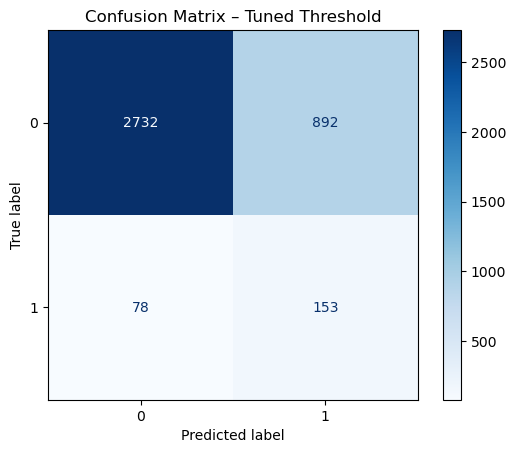

In [10]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(
    y_test,
    y_pred_final,
    cmap="Blues"
)

plt.title("Confusion Matrix – Tuned Threshold")
plt.show()


## Threshold Optimization Summary

The Random Forest model was optimized by tuning the classification threshold using predicted fraud probabilities.

Lowering the threshold significantly improved fraud recall, enabling the model to detect a higher proportion of fraudulent claims.

This approach aligns the model with business priorities, where missing fraud cases is costlier than investigating false positives.


## Threshold Optimization Results

Default classification threshold (0.5) resulted in very low fraud recall (9%), making the model unsuitable for real-world fraud detection.

Threshold tuning was performed using ROC and Precision–Recall analysis to identify an optimal operating point.

Key observations:

- Fraud recall improved significantly as the threshold decreased.
- Precision declined gradually but remained operationally manageable.
- The recall–specificity intersection zone was observed between 0.20 and 0.30.

A threshold of **0.25** was selected as the production decision boundary.

At this threshold:

- Fraud Recall: 66%
- Fraud Precision: 15%
- Accuracy: 75%

This configuration balances fraud detection capability with investigation workload, making the model operationally viable.
